In [2]:
%pip install google


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import spacy
from langdetect import detect, LangDetectException
import string
import re
from collections import Counter
from unidecode import unidecode
import io
from google.cloud import storage
import os


# Load the English language model for Spacy
nlp = spacy.load("en_core_web_sm")

def filter_and_update_categories(df):

    main_cat_counts = df['Main Category'].value_counts()
    freq_nouns = Counter()

    for index, row in df.iterrows():

        doc = nlp(row['Processed Text'])
        nouns = [token.text for token in doc if token.pos_ == 'NOUN']
        freq_nouns.update(nouns)

    df['Main Category'] = df['Main Category'].apply(
        lambda x: freq_nouns.most_common(1)[0][0] if main_cat_counts[x] < 10 else x
    )

    all_cats = Counter([cat for sublist in df['All Categories'].str.split(',').dropna() for cat in sublist])
    df['All Categories'] = df['All Categories'].str.split(',').apply(
        lambda cats: [cat.strip() for cat in cats if all_cats[cat.strip()] >= 10] if cats else []
    )


    df['All Categories'] = df['All Categories'].apply(
        lambda x: [word for word, count in freq_nouns.most_common(3)] if not x else x
    )

    return df

def get_top_words(text, n=10):
    """Return the most common words in the text."""
    words = re.findall(r'\w+', text)
    most_common_words = Counter(words).most_common(n)
    return most_common_words

def standardize_dates(df, date_column):
    """Standardizes the dates in a DataFrame column to the format 'YYYY-MM-DD'."""
    df[date_column] = df[date_column].apply(lambda date: parser.parse(date).strftime('%Y-%m-%d'))
    return df


def preprocess_text(text):
    """Processes the given text by cleaning and normalizing it."""
    text = text.lower().strip()  # Convert text to lowercase and strip whitespaces
    text = unidecode(text)  # Normalize text
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)  # Replace punctuation with space
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces into one
    text = re.sub(r'\d', ' ', text)  # Remove digits
    return text

def lemmatize_text(text):
    """Lemmatizes the given text, removing stopwords, very short words, and certain parts of speech."""
    doc = nlp(text)
    filtered_tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and len(token.lemma_) > 2 and token.lemma_.isalpha()
        and token.pos_ not in ['PRON', 'DET']
    ]
    return ' '.join(filtered_tokens)


def detect_english(text):
    """Detects if the given text is English."""
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

def filter_english_text(df, text_column):
    """Filters the DataFrame to only include rows where the text is English."""
    df['is_english'] = df[text_column].apply(detect_english)
    filtered_df = df[df['is_english']].drop(columns=['is_english'])
    return filtered_df

def get_most_frequent_word(text):
    """Extracts the most frequent word from the text."""
    words = text.split()
    if words:
        return Counter(words).most_common(1)[0][0]
    return None

def get_most_frequent_bigram(text):
    """Extracts the most frequent two-word combination from the text."""
    words = text.split()
    if len(words) > 1:
        bigrams = zip(words[:-1], words[1:])
        return ' '.join(Counter(bigrams).most_common(1)[0][0])
    return None


In [4]:
BUCKET_NAME = os.getenv("BUCKET_NAME")

def get_data_from_gcp(BUCKET_NAME, file_name):
    # Create a storage client
    storage_client = storage.Client()
    # Get the bucket
    bucket = storage_client.get_bucket(bucket_name)
    # Get the blob (file) from the bucket
    blob = bucket.get_blob(file_name)
    # Read the CSV file into a DataFrame
    df = pd.read_csv(io.BytesIO(blob.download_as_bytes()), sep=",")

    return df

In [66]:
file_name_list = ['cleaned_data/arxiv_cleaned.csv', 'cleaned_data/collective_evolution_cleaned.csv'\
                ,'cleaned_data/david_cleaned.csv', 'cleaned_data/ftcheck_cleaned.csv'\
                , 'cleaned_data/isha_cleaned.csv', 'cleaned_data/naturalnews_cleaned.csv', 'cleaned_data/astro_lipton_cleaned.csv']

In [15]:
#TODO concat the dfs into one big df called combined_df for simplicity

df_arxiv = get_data_from_gcp(BUCKET_NAME, file_name_list[0])
df_collective_evolution = get_data_from_gcp(BUCKET_NAME, file_name_list[1])
df_david = get_data_from_gcp(BUCKET_NAME, file_name_list[2])
df_factcheck = get_data_from_gcp(BUCKET_NAME, file_name_list[3])
df_isha = get_data_from_gcp(BUCKET_NAME, file_name_list[4])
df_naturalnews = get_data_from_gcp(BUCKET_NAME, file_name_list[5])

In [67]:
df_astro = get_data_from_gcp(BUCKET_NAME, file_name_list[6])

In [68]:
df_astro.columns

Index(['Unnamed: 0', 'Title', 'Author', 'Published Date', 'Main Body',
       'Word Count', 'Most Frequent Word', 'Most Frequent Word Count', 'Link',
       'Label', 'Primary Category', 'All Categories', 'Cleaned Body',
       'Processed Text', 'Most Frequent Word Combination'],
      dtype='object')

In [69]:
df_astro.drop(columns=['Unnamed: 0','Most Frequent Word Combination','Cleaned Body','Main Body','Most Frequent Word Count'], inplace=True)

In [71]:
df_astro = df_astro[['Title', 'Author', 'Published Date', 'Word Count', 'Most Frequent Word',
       'Link', 'Label', 'Primary Category', 'All Categories',
       'Processed Text']]

In [54]:
df_naturalnews.columns

Index(['Title', 'Published Date', 'Author', 'Main Category', 'All Categories',
       'Main Body', 'Word Count', 'Link', 'Label', 'Processed Text'],
      dtype='object')

In [55]:
df_naturalnews.drop(columns=['Main Body'], inplace=True)
df_naturalnews.rename(columns = {'Main Category':'Primary Category'}, inplace=True)
df_naturalnews['Most Frequent Word']=''

df_naturalnews.columns

In [60]:
 df_naturalnews = df_naturalnews[['Title', 'Author', 'Published Date', 'Word Count', 'Most Frequent Word',
        'Link', 'Label', 'Primary Category', 'All Categories',
        'Processed Text']]

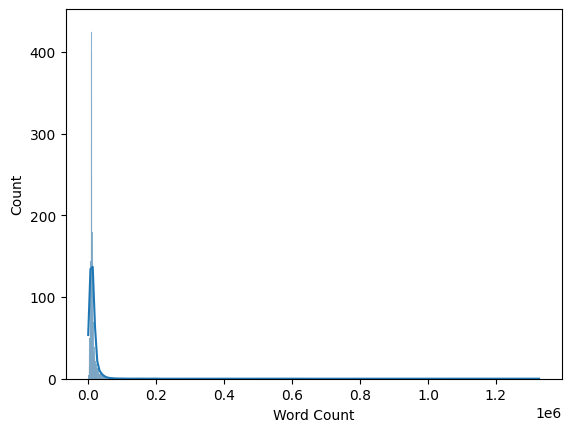

In [50]:
sns.histplot(df_naturalnews['Word Count'], kde=True);

In [72]:
final_df = pd.concat([df_arxiv, df_collective_evolution, df_david, df_isha, df_naturalnews, df_factcheck, df_astro], join = 'inner')
final_df.columns

Index(['Title', 'Author', 'Published Date', 'Word Count', 'Most Frequent Word',
       'Link', 'Label', 'Primary Category', 'All Categories',
       'Processed Text'],
      dtype='object')

In [73]:
combined_df = final_df

In [44]:
import matplotlib.pyplot as plt
from collections import Counter
def plot_word_count_distribution(df, column, title):
    """Plot the word count distribution of a text column."""
    word_counts = df[column].str.split().str.len()
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Word Count Distribution in {title}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_word_count_distribution(combined_df, 'Main Body', 'Original Texts')

NameError: name 'combined_df' is not defined

In [ ]:

def clean_text(text):
    """Further clean the text by removing numbers and non-alphanumeric characters, and converting to lowercase."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()
    return text

combined_df['Cleaned Body'] = combined_df['Main Body'].apply(clean_text)

all_cleaned_texts = ' '.join(combined_df['Cleaned Body'])
top_words = get_top_words(all_cleaned_texts, 10)

print("Top 10 Most Frequent Words:")
for word, count in top_words:
    print(f"{word}: {count}")


In [ ]:
def preprocessing_pipeline(df, text_column):
    """Applies text cleaning, English filtering, and updates most frequent words in a DataFrame."""
    df = df.dropna(subset=[text_column])
    df = filter_english_text(df, text_column)
    # df = standardize_dates(df, date_column)

    if not df.empty:
        df['Processed Text'] = df[text_column].apply(preprocess_text)
        df = filter_and_update_categories(df)
        df = lemmatize_text(df)
        df['Most Frequent Word'] = df['Processed Text'].apply(get_most_frequent_word)
       # df['Most Frequent Word Combination'] = df['Processed Text'].apply(get_most_frequent_bigram)

    return df


In [ ]:
updated_df = preprocessing_pipeline(combined_df, 'Main Body')

In [ ]:
plot_word_count_distribution(updated_df, 'Processed Text', 'Cleaned Texts')

In [ ]:
def clean_text(text):
    """Further clean the text by removing numbers and non-alphanumeric characters, and converting to lowercase."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()
    return text


all_cleaned_texts = ' '.join(updated_df['Processed Text'])
top_words = get_top_words(all_cleaned_texts, 10)

print("Top 10 Most Frequent Words:")
for word, count in top_words:
    print(f"{word}: {count}")


In [ ]:
'''for the next step of embedding in the pipeline'''
# from gensim.models import FastText
# import nltk
# import numpy as np
# from sklearn.base import BaseEstimator, TransformerMixin

# def tokenize_texts(text_list):
#     return [nltk.word_tokenize(text) for text in text_list]

# def create_fasttext_model(tokenized_texts, size=100, window=5, min_count=1, workers=4, sg=1):
#     model = FastText(tokenized_texts, size=size, window=window, min_count=min_count, workers=workers, sg=sg)
#     return model

# def prepare_word_vectors(model):
#     return {word: model.wv[word] for word in model.wv.vocab}

# class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.dim = len(next(iter(word2vec.values())))

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec.get(w, np.zeros(self.dim)) for w in words], axis=0)
#             for words in X
#         ])
